[View in Colaboratory](https://colab.research.google.com/github/SakshiPriya/gradcam/blob/master/gradcam.ipynb)

In [2]:
 !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
 !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
 !apt-get update -qq 2>&1 > /dev/null
 !apt-get -y install -qq google-drive-ocamlfuse fuse
 from google.colab import auth
 auth.authenticate_user()
 from oauth2client.client import GoogleCredentials
 creds = GoogleCredentials.get_application_default()
 import getpass
 !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
 vcode = getpass.getpass()
 !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive


In [4]:
!pip install torch
!pip install torchvision
!pip install pillow==4.0.0

    100% |████████████████████████████████| 519.5MB 18kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x55df56738000 @  0x7fe1920eb1c4 0x55defce790d8 0x55defcf62d5d 0x55defce8c77a 0x55defce91462 0x55defce89b3a 0x55defce9182e 0x55defce89b3a 0x55defce9182e 0x55defce89b3a 0x55defce9182e 0x55defce89b3a 0x55defce91e1f 0x55defce89b3a 0x55defce9182e 0x55defce89b3a 0x55defce9182e 0x55defce91462 0x55defce91462 0x55defce89b3a 0x55defce91e1f 0x55defce91462 0x55defce89b3a 0x55defce91e1f 0x55defce89b3a 0x55defce91e1f 0x55defce89b3a 0x55defce9182e 0x55defce89b3a 0x55defceba50f 0x55defceb5202
    100% |████████████████████████████████| 61kB 2.2MB/s 
    100% |████████████████████████████████| 2.0MB 5.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.6MB 2.9MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing in

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms,models
from PIL import Image
from torch import nn
import cv2

In [0]:
mean=torch.Tensor([0.485, 0.456, 0.406])
std=torch.Tensor([0.229, 0.224, 0.225])

def transformimage(image):
  transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean,std)])
  transformedimage=transform(image)
  transformedimage=transformedimage.unsqueeze(0)
  return transformedimage
  

In [0]:
listofimages=[['drive/app/goldfish.jpg',1],
              ['drive/app/hamster.jpg',333],
              ['drive/app/jellyfish.jpg',107]]
index=0
imgpath=listofimages[index][0]
classid=listofimages[index][1]
model=models.vgg19(pretrained=True)
image=Image.open(imgpath)
imagetensor=transformimage(image)



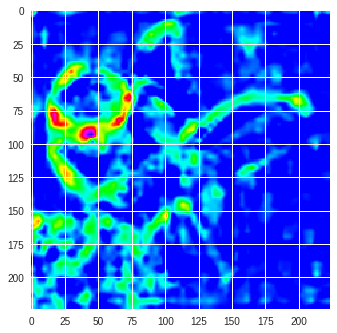

In [10]:
class gradcam():
  def __init__(self,model,targetlayer):
    self.model=model
    self.tl=targetlayer
    self.model.eval()
    self.attachinghook()
  def attachinghook(self):
     def hookfunc(module,grad_in,grad_out):
       self.grad=grad_out
     i=0
     for layer in self.model.features:
         if i==self.tl:
           layer.register_backward_hook(hookfunc)
         i+=1
    
  def outputeval(self,x):
     i=0
     for layer in self.model.features:
        x=layer(x)
        if i==self.tl:
           layerout=x
        i+=1  
     x=x.view(x.size()[0],-1)    
     x=self.model.classifier(x)
     return layerout,x

  def imagevaluation(self,imageten):
    self.model.zero_grad()
    lt,ft=self.outputeval(imageten)
    gradient=torch.zeros_like(ft)
    gradient[0][classid]=1
    ft.backward(gradient)
    grad=self.grad[0].numpy()
    
    lt=lt.data.numpy()
    alpha=np.mean(grad,axis=(2,3))
    cam=np.zeros(lt[0][0].shape)
    
    for i in range(len(alpha[0])):
      cam+=alpha[0][i]*lt[0][i]
    
    cam=cv2.resize(cam,(224,224))
    camrelu=np.maximum(cam,0)
    return camrelu
  
  def heatmap(self,image,imagetensor):
    
    camrelu=self.imagevaluation(imagetensor)
    camrelu =(camrelu - np.min(camrelu)) / (np.max(camrelu) - np.min(camrelu))
    camrelu = np.uint8(camrelu * 255)
    heatmap = cv2.applyColorMap(camrelu, cv2.COLORMAP_HSV)
    plt.figure()
    plt.imshow(heatmap)
    plt.show()
    
targetlayer=11
gc=gradcam(model,targetlayer)
gc.heatmap(image,imagetensor)
